In [1]:
import os
os.environ['http_proxy'] = '127.0.0.1:7890'
os.environ['https_proxy'] = '127.0.0.1:7890'

In [2]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import difflib
import sys
import glob

from tqdm.auto import tqdm
from pprint import pprint

import plotnine
from plotnine import *

from dfply import *

In [3]:
# authenticate earthengine api
ee.Initialize()

In [4]:
from Modules.Modules import filter_exclude, get_img_df, compute_mean_ci
from Modules.Parallize_df import parallelize_dataframe

# might need reload modules as the code progrocessing
%load_ext autoreload
%autoreload 2

In [5]:
# import GAEZ data from ee_asset
GAEZ_list = ! earthengine ls users/wangjinzhulala/Paper_3/03_GAEZ

# get the admin shp
NCP_provinces = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")

# get the GAEZ pixel size
GAEZ_pix_scale = ee.Image("users/wangjinzhulala/Paper_3/03_GAEZ/GAEZ_2_Moisture_Annual_P_PET_1981_2010_Historical").projection().nominalScale().getInfo()

In [6]:
# pair Chinese city names with english spelling
city_cn_en = dict(zip(['北京市','天津市', '河北省','江苏省', '安徽省', '河南省', '山东省'],
             ['Beijing','Tianjin', 'Hebei','Jiangsu', 'Anhui', 'Henan', 'Shandong']))

### Compute the difference between GAEZ_yield and yearbook_yield records

In [7]:
# read data
crop_yield_history_1975_2020 = pd.read_csv('./result_csv/crop_yield_history_1975_2020.csv')
GYGA_weighted_by_area_ratio = pd.read_csv('./result_csv/GYGA_weighted_by_area_ratio.csv')

GAEZ_attainable_t_ha_forced_with_GYGA = pd.read_pickle('./result_csv/GAEZ_attainable_t_ha_forced_with_GYGA.pkl')
GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul = pd.read_csv('./result_csv/GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul.csv')

#### Plot the original value to see the difference 

In [8]:
# get the actual GAEZ crop yield (t) with water supply in 2010
GAEZ_yield_2010 = get_img_df(img_path = GAEZ_list,
                theme = 'GAEZ_5',
                variable = 'Yield',
                time = '2010',
                crop = ['Maize','Wetland_rice','Wheat'],
                water = ['Irrigated','Rainfed'])

# formatting and add infos
GAEZ_yield_2010['image'] = GAEZ_yield_2010['GEE_path'].apply(lambda x:ee.Image(x))
GAEZ_yield_2010 = GAEZ_yield_2010.rename(columns={'time':'year'})
GAEZ_yield_2010 = GAEZ_yield_2010.drop('GEE_path',1)
GAEZ_yield_2010['rcp'] = 'GAEZ_actual'
GAEZ_yield_2010

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5908\335428358.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


,theme,variable,year,crop,water,image,rcp
0,GAEZ_5,Yield,2010,Maize,Irrigated,"ee.Image({\n ""functionInvocationValue"": {\n ...",GAEZ_actual
1,GAEZ_5,Yield,2010,Maize,Rainfed,"ee.Image({\n ""functionInvocationValue"": {\n ...",GAEZ_actual
2,GAEZ_5,Yield,2010,Wetland_rice,Irrigated,"ee.Image({\n ""functionInvocationValue"": {\n ...",GAEZ_actual
3,GAEZ_5,Yield,2010,Wetland_rice,Rainfed,"ee.Image({\n ""functionInvocationValue"": {\n ...",GAEZ_actual
4,GAEZ_5,Yield,2010,Wheat,Irrigated,"ee.Image({\n ""functionInvocationValue"": {\n ...",GAEZ_actual
5,GAEZ_5,Yield,2010,Wheat,Rainfed,"ee.Image({\n ""functionInvocationValue"": {\n ...",GAEZ_actual


In [9]:
def compute_area_weighted_mean(df):

  ##################### Multiply each crop_water with its area_ratio #############
  # read the harvested area ratio so we can compute the weigted mean attainable yield
  area_ratio = pd.read_pickle('./result_csv/harvested_area_ratio.pkl')
  df = df.merge(area_ratio,on=['crop','water'])

  # compute the area_weighted actual yield
  df['val_area_weighted'] = df.apply(lambda x:x['image'].multiply(x['area_ratio']),1)

  ##################### Sum the area_weighted yield #############
  stats_dict = {}
  for idx,df in df.groupby(['crop','year','rcp']):

    img_val = ee.ImageCollection(df['val_area_weighted'].tolist()).sum()

    stats_dict[idx] = {'img_val':img_val}

  ##################### make the stats a sensibel df #############
  out_df = pd.DataFrame(stats_dict).T.reset_index()
  out_df = out_df.rename(columns={'level_0':'crop','level_1':'year','level_2':'rcp'})

  return out_df

In [10]:
# function to get attianable yield for each province
def compute_yield_each_province(in_df):

  # hack to show progress bar
  print(' ',end='',flush=True)

  df_list = []

  # compute the attainable yield in each provinces
  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):
    crop = row['crop']
    year = row['year']
    rcp = row['rcp']

    img = row['img_val'].toFloat()

    # compute stats from GEE
    stats = img.reduceRegions(collection=NCP_provinces,reducer='mean',scale=GAEZ_pix_scale).getInfo()

    # get data
    stats_df = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['mean']] for i in stats['features']}).T

    # append infomation
    stats_df = stats_df.reset_index()
    stats_df.columns=['Province','Mean Production']
    stats_df['crop'] = crop
    stats_df['year'] = year
    stats_df['rcp'] = rcp
    
    # store df                        
    df_list.append(stats_df)

  # concat dfs
  out_df = pd.concat(df_list,ignore_index=True)
  
  return out_df

In [11]:
# 1) first get area_weighted mean attainable yield (t/ha)
GAEZ_yield_2010_area_weighted_mean = compute_area_weighted_mean(GAEZ_yield_2010)

# 2) then get mean attainable yield (t/ha) in each province
GAEZ_yield_2010_area_weighted_mean_each_province = parallelize_dataframe(GAEZ_yield_2010_area_weighted_mean,compute_yield_each_province,3)

# 3) extend the year column for plot making
GAEZ_yield_2010_area_weighted_mean_each_province_for_plot = GAEZ_yield_2010_area_weighted_mean_each_province.copy()
GAEZ_yield_2010_area_weighted_mean_each_province_for_plot['year'] = [[2005,2015]]*len(GAEZ_yield_2010_area_weighted_mean_each_province_for_plot)
GAEZ_yield_2010_area_weighted_mean_each_province_for_plot = GAEZ_yield_2010_area_weighted_mean_each_province_for_plot.explode('year')
GAEZ_yield_2010_area_weighted_mean_each_province_for_plot['year'] = GAEZ_yield_2010_area_weighted_mean_each_province_for_plot['year'].astype('int')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

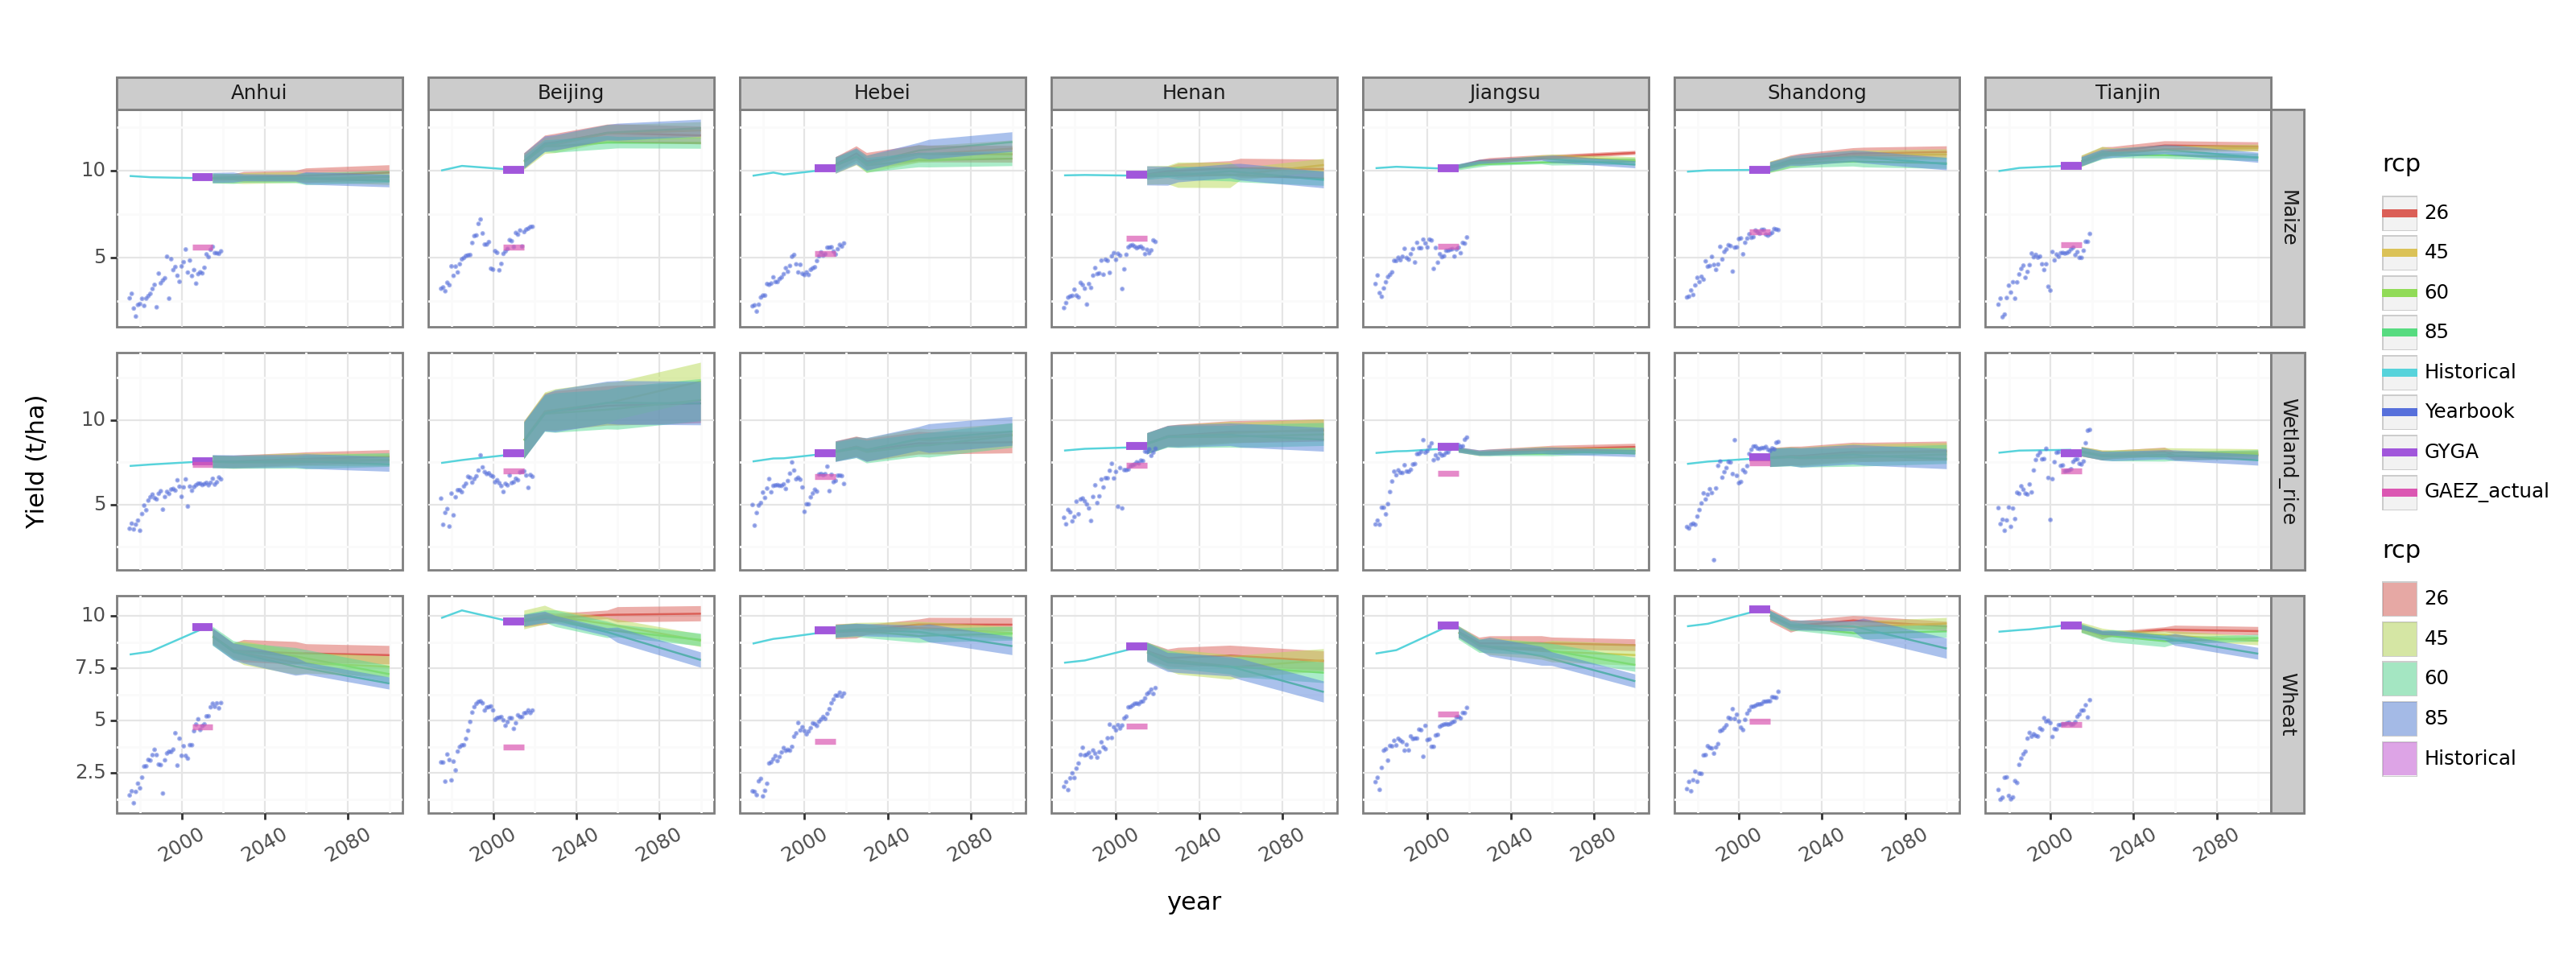

<Figure Size: (1600 x 600)>

In [12]:
# plot the GAEZ/Yearbook data
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

(ggplot() +
 # GAEZ attainable yiel
 geom_line(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, aes('year','Mean Production',color='rcp')) +
 geom_ribbon(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.5) +
 # yearbook history
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production',color='rcp'),alpha=0.5,size=0.2) +
 # GYGA attainable
 geom_line(GYGA_weighted_by_area_ratio, aes('year','Mean Production',color='rcp'),size=2) +
 # GAEZ_2010 yield
 geom_line(GAEZ_yield_2010_area_weighted_mean_each_province_for_plot, aes('year','Mean Production',color='rcp'),size=1.5,alpha=0.7) +
 facet_grid('crop~Province',scales='free') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Yield (t/ha)')
)

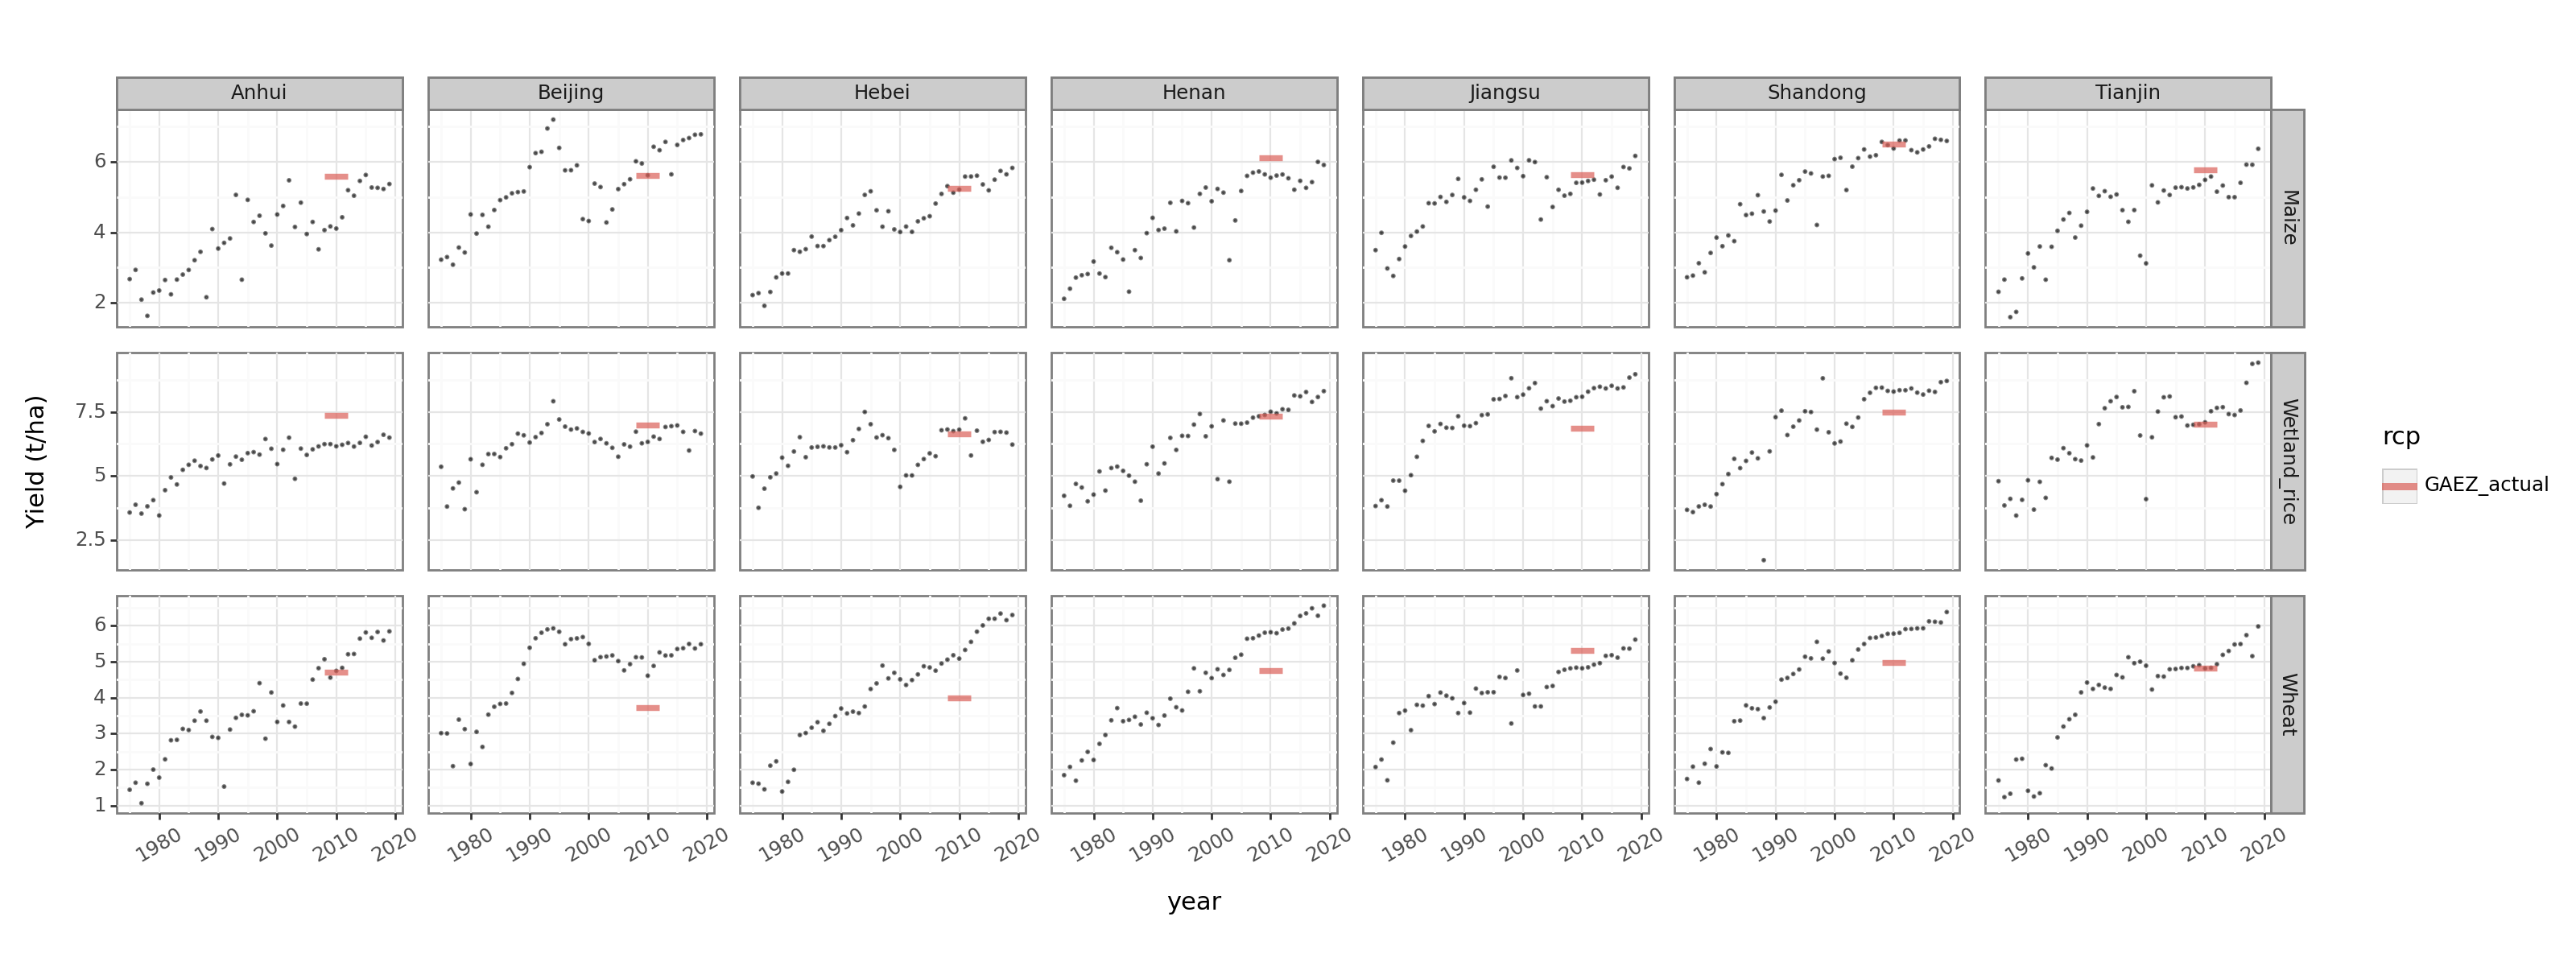

<Figure Size: (1600 x 600)>

In [13]:
# data for compare GEAZ_yield and yearbook_yield
GAEZ_yield_2010_temp = GAEZ_yield_2010_area_weighted_mean_each_province_for_plot.replace({2005:2008,2015:2012})

# plot the GAEZ/Yearbook data
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

g = (ggplot() +
 # yearbook history
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production'),alpha=0.5,size=0.2) +
 # GAEZ_2010 yield
 geom_line(GAEZ_yield_2010_temp, aes('year','Mean Production',color='rcp'),size=1.5,alpha=0.7) +
 facet_grid('crop~Province',scales='free') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Yield (t/ha)')
)

g

In [14]:
g.save('../Figs/sup_11_compare_yield_2010_between_GAEZ_yearbook.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 16 x 6 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/sup_11_compare_yield_2010_between_GAEZ_yearbook.svg


#### Force GAEZ_actual_yield_2010 to agree with yearbook_2010

In [15]:
# filter the 2010 records
crop_yield_history_2010 = crop_yield_history_1975_2020[crop_yield_history_1975_2020['year']==2010]

# merge GAEZ to yearbook
yield_yearbook_GAEZ_2010 = crop_yield_history_2010.merge(GAEZ_yield_2010_area_weighted_mean_each_province,on=['crop','Province'])

yield_yearbook_GAEZ_2010['yearbook_GAEZ_delta'] = yield_yearbook_GAEZ_2010['Mean Production_x'] - yield_yearbook_GAEZ_2010['Mean Production_y']
yield_yearbook_GAEZ_2010_delta = yield_yearbook_GAEZ_2010[['crop','Province','yearbook_GAEZ_delta']]

In [16]:
# create the delta img for each province
delta_mosaics = {}
for idx,df in yield_yearbook_GAEZ_2010_delta.groupby('crop'):
  province_delta_dict = zip(df['Province'],df['yearbook_GAEZ_delta'])

  shps = []
  for province,val in province_delta_dict:
    shp = NCP_provinces.filterMetadata('EN_Name','equals',province).first()
    shp = shp.set('crop',idx,'Name',province,'delta',val)
    shps.append(shp)

  fe_col = ee.FeatureCollection(shps)

  delta_mosaics[idx] = [ee.Image(0).toFloat().paint(featureCollection =fe_col,color='delta')]

# get the mosaiced imgs
delta_mosiac_img = pd.DataFrame(delta_mosaics).T.reset_index()
delta_mosiac_img.columns = ['crop','delta_img']

In [17]:
# add the delta_img to GAEZ_attainable_2010
GAEZ_actual_forced_with_Yearbook = GAEZ_yield_2010.merge(delta_mosiac_img,on='crop')
GAEZ_actual_forced_with_Yearbook['image'] = GAEZ_actual_forced_with_Yearbook.apply(lambda row:row['image'].add(row['delta_img']),1)

GAEZ_actual_forced_with_Yearbook = GAEZ_actual_forced_with_Yearbook.drop('delta_img',1)
GAEZ_actual_forced_with_Yearbook.to_pickle('./result_csv/GAEZ_actual_forced_with_Yearbook.pkl')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5908\1499229004.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


#### Check if the forcement is successful

In [18]:
# 1) first get area_weighted mean attainable yield (t/ha)
GAEZ_yield_2010_area_weighted_mean_add_delta = compute_area_weighted_mean(GAEZ_actual_forced_with_Yearbook)

# 2) then get mean attainable yield (t/ha) in each province
GAEZ_actual_forced_with_Yearbook_weighted_mean = parallelize_dataframe(GAEZ_yield_2010_area_weighted_mean_add_delta,compute_yield_each_province,3)

# 3) extend the year column for plot making
GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot = GAEZ_actual_forced_with_Yearbook_weighted_mean.copy()
GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot['year'] = [[2005,2015]]*len(GAEZ_actual_forced_with_Yearbook_weighted_mean)

GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot = GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot.explode('year')
GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot['year'] = GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot['year'].astype('int')

GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot.to_csv('./result_csv/GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot.csv',index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

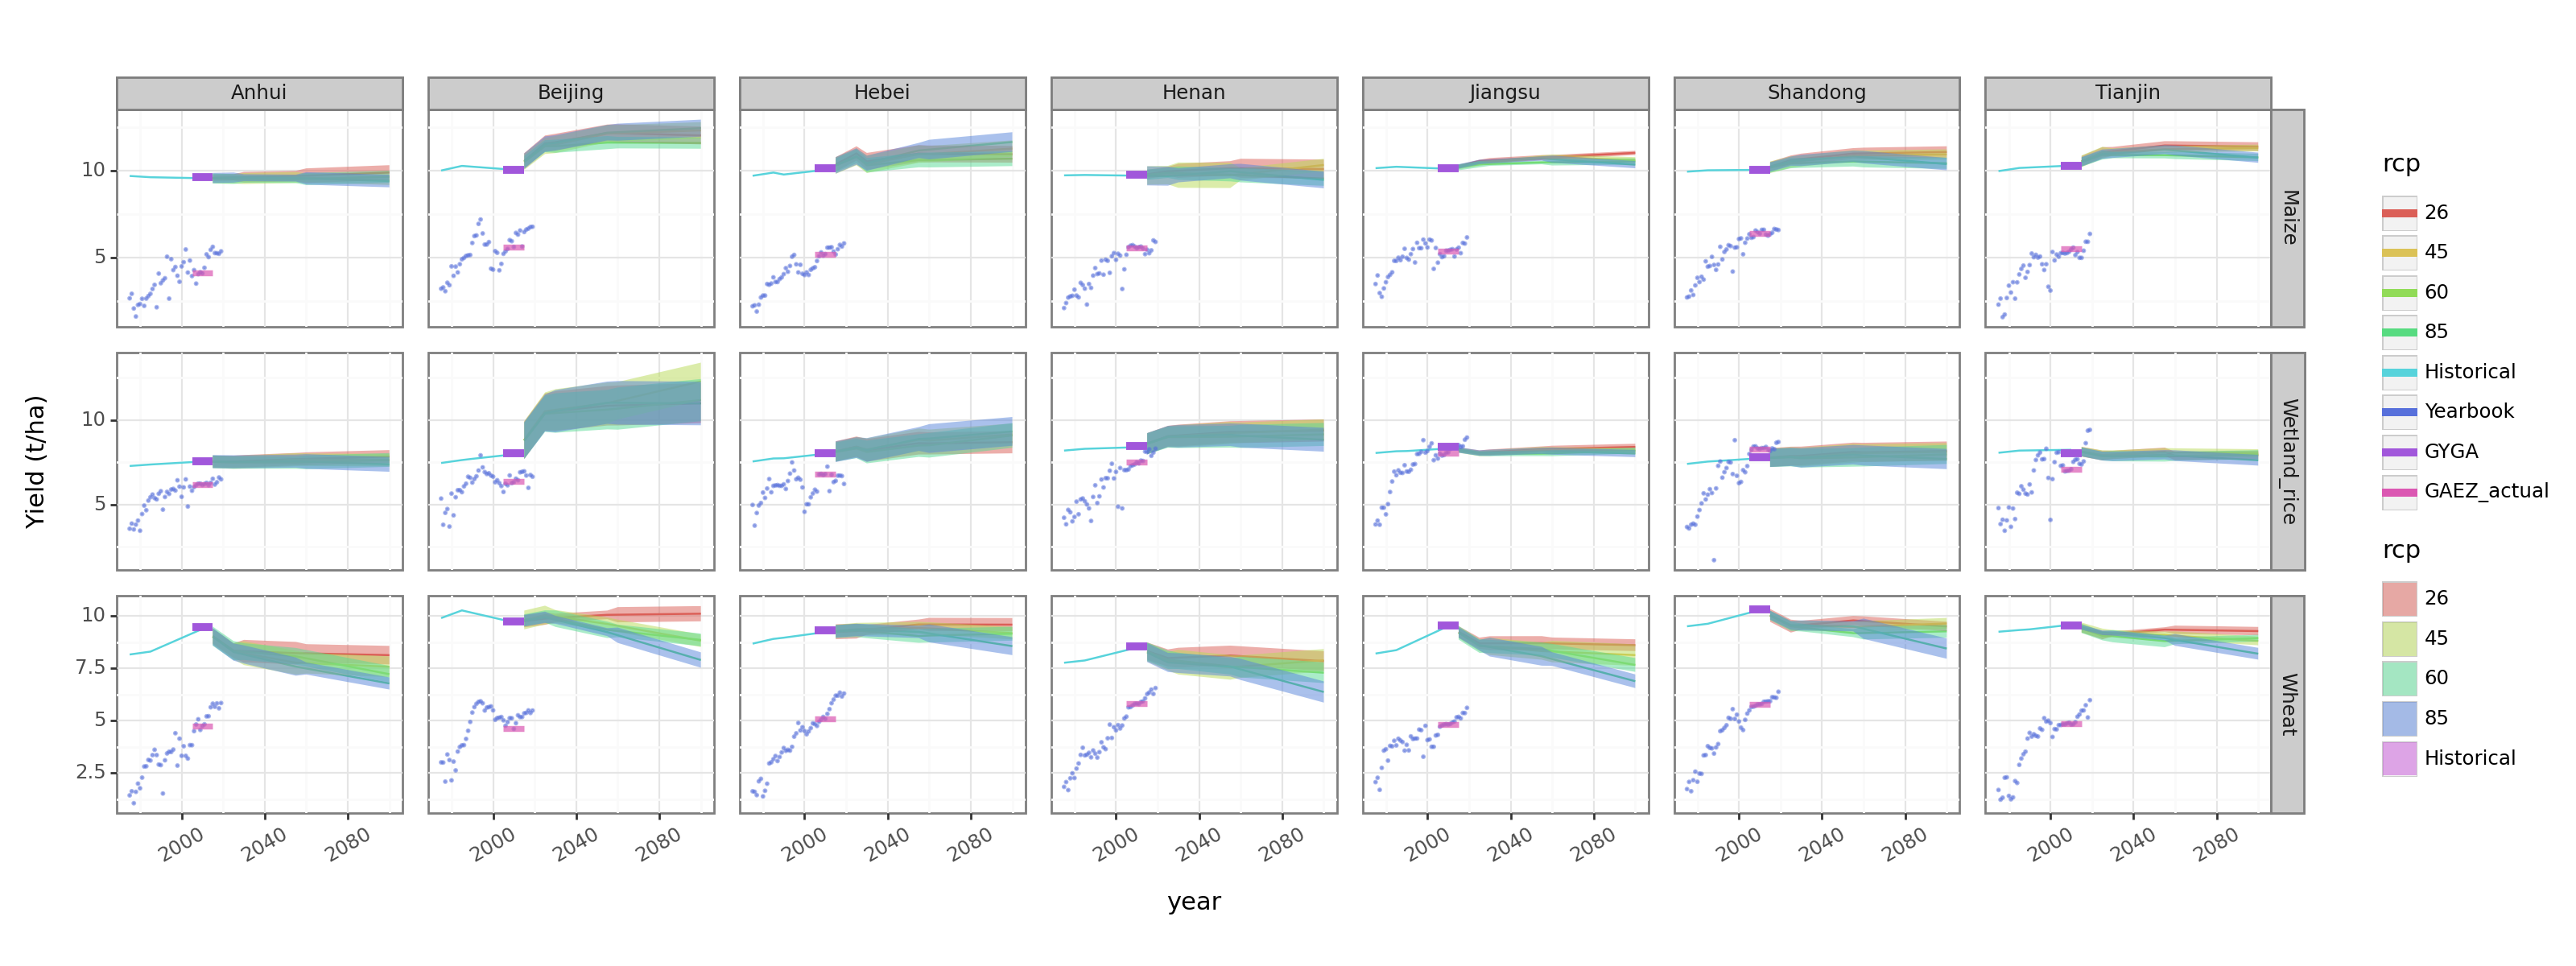

<Figure Size: (1600 x 600)>

In [19]:
# plot the GAEZ/Yearbook data
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

(ggplot() +
 geom_line(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, aes('year','Mean Production',color='rcp')) +
 geom_ribbon(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.5) +
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production',color='rcp'),alpha=0.5,size=0.2) +
 geom_line(GYGA_weighted_by_area_ratio, aes('year','Mean Production',color='rcp'),size=2) +
 geom_line(GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot, aes('year','Mean Production',color='rcp'),size=1.5,alpha=0.7) +
 facet_grid('crop~Province',scales='free') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Yield (t/ha)')
)